# Reducing Loss of Name Generation Neural Network

I can't get the loss of this neural network to go below 2, so I'm using this notebook to try different ways to achieve this.

## Setup

In [1]:
from collections import defaultdict, OrderedDict
import math
import random
import time
from typing import Callable, cast, Dict, List, Literal, Tuple, Union

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.neighbors
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

%matplotlib inline

Hopefully we have CUDA.

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

Torch version: 2.5.1
CUDA available: True
CUDA version: 12.4
Current device: 0
Device name: NVIDIA GeForce RTX 3060


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CUDA


Seed random number generators for reproducibility.

In [4]:
RANDOM_SEED = 42
TORCH_GENERATOR_SEED = 2147483647

random.seed(RANDOM_SEED)
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

Load dataset of names.

In [5]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32034

Two dictionaries will help us convert between integers and strings:

- `stoi` - string to integer

- `itos` - integer to string

In [7]:
chars = sorted(list(set(str().join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Our vocabulary is the set of all possible values that the model can generate.

In [8]:
vocab_size = len(itos)
vocab_size

27

Build datasets by generating examples from the list of names. An example consists of part of a name as input and the next letter in the name as output. This is what the `build_dataset` function is doing:

```
b = block size;
for word in words:
    initialize context vector to b empty characters;
    for ch in word:
        // Context is the first b characters, ch is the next character
        add context to the input list;
        add ch to the output list;
        shift context elements to the left, append ch
```

In [9]:
def build_dataset(words: List[str], block_size: int, device = None):
    X_data, Y_data = [], []
    for word in words:
        context = [0 for _ in range(block_size)]
        for ch in word + '.':
            ix = stoi[ch]

            X_data.append(context)
            Y_data.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X_data, device=device)
    Y = torch.tensor(Y_data, device=device)
    return X, Y

In [10]:
block_size = 12

random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_tr, Y_tr = build_dataset(words[:n1], block_size, device)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size, device)
X_te, Y_te = build_dataset(words[n2:], block_size, device)

print(f'{X_tr.shape=}, {Y_tr.shape=}\n{X_dev.shape=}, {Y_dev.shape=}\n{X_te.shape=}, {Y_te.shape=}')

X_tr.shape=torch.Size([182620, 12]), Y_tr.shape=torch.Size([182620])
X_dev.shape=torch.Size([22664, 12]), Y_dev.shape=torch.Size([22664])
X_te.shape=torch.Size([22869, 12]), Y_te.shape=torch.Size([22869])


The `loss_of_split` function calculates the loss of a model over a dataset (either the training, validation, or testing dataset).

In [11]:
@torch.no_grad()
def loss_of_split(
    split: Literal['train'] | Literal['test'] | Literal['val'],
    model: torch.nn.Sequential,
    device=None,
    silent=False
) -> torch.types.Number:
    x, y = {
        'train': (X_tr, Y_tr),
        'val': (X_dev, Y_dev),
        'test': (X_te, Y_te)
    }[split]

    logits = model(x.to(device))
    loss = F.cross_entropy(logits, y)

    if not silent:
        print(f'Loss of \'{split}\' split: {loss.item():.4f}')

    return loss.item()

We use a custom layer in our network, which essentially groups inputs in groups of two. This helps the network understand patterns in groups.

In [12]:
class FlattenConsecutive(torch.nn.Module):

    n: int

    def __init__(self, n: int):
        super().__init__()
        self.n = n

    def forward(self, x: Tensor) -> Tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        # This is essentially doing:
        #     half1 = x[:,::2,:]                   // Get all even indices of second dimension
        #     half2 = x[:,1::2,:]                  // Get all odd indices of second dimension
        #     x = torch.cat((half1, half2), dim=2) // Concatenate the two halves onto each other
        if x.shape[1] == 1:
            x = x.squeeze(1)
        return x

Here is where we define the network. Since the block size is 8, we have three `FlattenConsecutive` characters (first layer separates 8 into two groups of 4, next layer separates 4 into two groups of 2, last layer separates 2 into two groups of 1).

After each `FlattenConsecutive` layer, there is a linear layer, then a layer normalization layer, than a tanh nonlinearity layer. The first layer of the network is the embedding layer (basically a lookup table), and the last layer is a final linear layer.

We also adjust the output layer weights by reducing it by 95%. This (hopefully) keeps the network more stable.

In [13]:
n_embd = 16
n_hidden = 512

g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED)

layers: OrderedDict[str, nn.Module] = OrderedDict([
    ('emb', nn.Embedding(vocab_size, n_embd, device=device)),

    ('flat1', FlattenConsecutive(3)),
    ('lin1', nn.Linear(n_embd * 3, 512, bias=True, device=device)),
    ('norm1', nn.LayerNorm(512, device=device)),
    ('tanh1', nn.Tanh()),
    # ('gelu1', nn.GELU()),

    # ('flat2', FlattenConsecutive(1)),
    # ('lin2', nn.Linear(n_hidden, n_hidden // 2, bias=False, device=device)),
    # ('norm2', nn.LayerNorm(n_hidden // 2, device=device)),
    # ('tanh2', nn.Tanh()),
    # ('gelu2', nn.GELU()),

    ('flat3', FlattenConsecutive(2)),
    ('lin3', nn.Linear(1024, 256, bias=True, device=device)),
    ('norm3', nn.LayerNorm(256, device=device)),
    ('tanh3', nn.Tanh()),
    # ('gelu3', nn.GELU()),

    ('flat4', FlattenConsecutive(2)),
    ('lin4', nn.Linear(512, 128, bias=True, device=device)),
    ('norm4', nn.LayerNorm(128, device=device)),
    ('tanh4', nn.Tanh()),
    # ('gelu4', nn.GELU()),

    ('out', nn.Linear(128, vocab_size, device=device))
])

model = torch.nn.Sequential(layers)

with torch.no_grad():
    model.out.weight *= 0.01

for p in model.parameters():
    p.requires_grad = True
print(f'Number of parameters: {sum(p.nelement() for p in model.parameters())}')

Number of parameters: 358859


This is a hook which captures outputs during training. Useful for debugging.

In [14]:
COLLECT = False
EPOCH = 0
tanh_outputs: Dict[str, List[Tensor]] = defaultdict(list)
tanh_output_data = []
gelu_output_data = []

def capture_tanh_hook(name: str) -> Callable[[nn.Module, Tuple[torch.Tensor, ...], Union[torch.Tensor, Tuple[torch.Tensor, ...]]], None]:
    def hook(
        module: nn.Module,
        input: Tuple[Tensor, ...],
        output: Tensor | Tuple[Tensor, ...]
    ) -> None:
        global COLLECT
        global EPOCH
        global tanh_output_data
        global tanh_outputs
        if COLLECT:
            if isinstance(output, Tensor):
                tanh_outputs[name].append(output.cpu())
                o = output.view(-1).cpu().numpy()
                tanh_output_data.extend([(name, EPOCH, num) for num in o])
    return hook

def capture_gelu_hook(name: str) -> Callable[[nn.Module, Tuple[torch.Tensor, ...], Union[torch.Tensor, Tuple[torch.Tensor, ...]]], None]:
    def hook(
        module: nn.Module,
        input: Tuple[Tensor, ...],
        output: Tensor | Tuple[Tensor, ...]
    ) -> None:
        global COLLECT
        global EPOCH
        global gelu_output_data
        if COLLECT:
            if isinstance(output, Tensor):
                o = output.view(-1).cpu().numpy()
                gelu_output_data.extend([(name, EPOCH, num) for num in o])
    return hook

for name, module in model.named_children():
    if isinstance(module, nn.Tanh):
        module.register_forward_hook(capture_tanh_hook(name))
    if isinstance(module, nn.GELU):
        module.register_forward_hook(capture_gelu_hook(name))

In [15]:
initial_embeddings = model.emb.weight.detach().clone().cpu()

In [16]:
def print_shape_hook(name: str) -> Callable[[nn.Module, Tuple[torch.Tensor, ...], Union[torch.Tensor, Tuple[torch.Tensor, ...]]], None]:
    def hook(
        module: nn.Module,
        input: Tuple[Tensor, ...],
        output: Tensor | Tuple[Tensor, ...]
    ) -> None:
        input_shape = None
        output_shape = None
        if len(input) > 0:
            if isinstance(input[0], Tensor):
                input_shape = str(tuple(input[0].shape))
        if isinstance(output, Tensor):
            # print(f'{name}, {tuple(output.shape)}')
            output_shape = str(tuple(output.shape))
        print(f'{name:<6} in: {input_shape if input_shape is not None else "???":<15} out: {output_shape if output_shape is not None else "???":<15}')
    return hook

remove_handles = []
for name, module in model.named_children():
    remove_handles.append(module.register_forward_hook(print_shape_hook(name)))

ix = torch.randint(0, X_tr.shape[0], (100,), generator=g, device=device)
Xb, Yb = X_tr[ix], Y_tr[ix]

model.eval()

print(f'{"input":<6} in: {"null":<15} out: {str(tuple(Xb.shape)):<15}')
# print(f'input, {Xb.shape}')
with torch.no_grad():
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

for remove_handle in remove_handles:
    remove_handle.remove()

input  in: null            out: (100, 12)      
emb    in: (100, 12)       out: (100, 12, 16)  
flat1  in: (100, 12, 16)   out: (100, 4, 48)   
lin1   in: (100, 4, 48)    out: (100, 4, 512)  
norm1  in: (100, 4, 512)   out: (100, 4, 512)  
tanh1  in: (100, 4, 512)   out: (100, 4, 512)  
flat3  in: (100, 4, 512)   out: (100, 2, 1024) 
lin3   in: (100, 2, 1024)  out: (100, 2, 256)  
norm3  in: (100, 2, 256)   out: (100, 2, 256)  
tanh3  in: (100, 2, 256)   out: (100, 2, 256)  
flat4  in: (100, 2, 256)   out: (100, 512)     
lin4   in: (100, 512)      out: (100, 128)     
norm4  in: (100, 128)      out: (100, 128)     
tanh4  in: (100, 128)      out: (100, 128)     
out    in: (100, 128)      out: (100, 27)      


In [17]:
norm4_input_data = []
norm4_weight_means = []
norm4_weight_stds = []
norm4_bias_means = []
norm4_bias_stds = []

def capture_norm4_input_hook(name: str) -> Callable[[nn.Module, Tuple[torch.Tensor, ...], Union[torch.Tensor, Tuple[torch.Tensor, ...]]], None]:
    def hook(
        module: nn.Module,
        input: Tuple[Tensor, ...],
        output: Tensor | Tuple[Tensor, ...]
    ) -> None:
        global COLLECT
        global EPOCH
        global norm4_input_data
        if COLLECT:
            norm4_weight_means.append(module.weight.clone().cpu().numpy().mean())
            norm4_weight_stds.append(module.weight.clone().cpu().numpy().std())
            norm4_bias_means.append(module.bias.clone().cpu().numpy().mean())
            norm4_bias_stds.append(module.bias.clone().cpu().numpy().std())
            if len(input) > 0:
                input_tensor = input[0]
                if isinstance(input_tensor, Tensor):
                    o = input_tensor.view(-1).cpu().numpy()
                    norm4_input_data.extend([(name, EPOCH, num) for num in o])
    return hook

model.norm4.register_forward_hook(capture_norm4_input_hook('norm4'))

In [18]:
Xb.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
        19, 20, 21, 22, 24, 25, 26], device='cuda:0')

## Training Loop

In [19]:
max_steps = 2_000
batch_size = 64
epochs = 25

lossi = []
tr_loss = []
val_loss = []
ud = []
ud_detail = []
logits_debug: List[Tensor] = []

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
scaler = torch.amp.GradScaler('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(epochs):
    # steps = max_steps + 1000 * epoch
    model.train()
    for i in range(max_steps):

        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]
        # print(Yb.shape)
        # raise

        optimizer.zero_grad()

        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            logits = model(Xb)
            loss = F.cross_entropy(logits, Yb)

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer) # Must unscale gradients before clipping with AMP
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=15.0) # Or a different max_norm

        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            param_updates = []
            for name, p in model.named_parameters():
                if p.grad is not None:
                    param_std = p.data.std()
                    update_ratio = (scheduler.get_last_lr()[0] * p.grad).std() / (param_std + 1e-8)
                    param_updates.append((name, update_ratio.log10().item()))
                else:
                    pass
            ud_detail.append(param_updates)

        with torch.no_grad():
            ud.append([((scheduler.get_last_lr()[0]*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

        # if max_steps < 10 or i % int(max_steps / 10) == 0:
            # print(f'\tIteration: {i}/{max_steps}, Loss: {loss.item():.4f}, Learning rate: {scheduler.get_last_lr()[0]}')

        lossi.append(loss.log10())

    model.eval()
    tr_loss.append(loss_of_split('train', model, silent=True))
    val_loss.append(loss_of_split('val', model, silent=True))
    COLLECT = True
    EPOCH = epoch
    with torch.no_grad():
        ix = torch.randint(0, X_tr.shape[0], (batch_size,), generator=g, device=device)
        Xb, Yb = X_tr[ix], Y_tr[ix]
        logits = model(Xb)
        logits_debug.append(logits.clone().cpu())
    COLLECT = False
    print(f'Epoch {epoch}, Training Loss: {tr_loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}, Learning rate: {scheduler.get_last_lr()[0]:.8f}')
    scheduler.step()

Epoch 0, Training Loss: 2.2064, Validation Loss: 2.2225, Learning rate: 0.10000000
Epoch 1, Training Loss: 2.1423, Validation Loss: 2.1723, Learning rate: 0.10000000
Epoch 2, Training Loss: 2.0878, Validation Loss: 2.1248, Learning rate: 0.07000000
Epoch 3, Training Loss: 2.0646, Validation Loss: 2.1160, Learning rate: 0.07000000
Epoch 4, Training Loss: 2.0270, Validation Loss: 2.0827, Learning rate: 0.04900000
Epoch 5, Training Loss: 2.0064, Validation Loss: 2.0703, Learning rate: 0.04900000
Epoch 6, Training Loss: 1.9848, Validation Loss: 2.0623, Learning rate: 0.03430000
Epoch 7, Training Loss: 1.9704, Validation Loss: 2.0543, Learning rate: 0.03430000
Epoch 8, Training Loss: 1.9395, Validation Loss: 2.0339, Learning rate: 0.02401000
Epoch 9, Training Loss: 1.9337, Validation Loss: 2.0335, Learning rate: 0.02401000
Epoch 10, Training Loss: 1.9179, Validation Loss: 2.0274, Learning rate: 0.01680700
Epoch 11, Training Loss: 1.9105, Validation Loss: 2.0301, Learning rate: 0.01680700
Ep

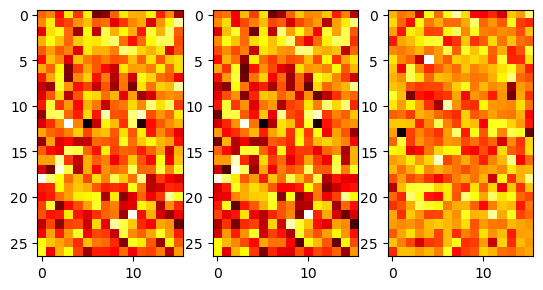

In [20]:
final_embeddings = model.emb.weight.detach().clone().cpu()
fig, ax = plt.subplots(1, 3)
ax[0].imshow(initial_embeddings, cmap='hot')
ax[1].imshow(final_embeddings, cmap='hot')
ax[2].imshow(final_embeddings-initial_embeddings, cmap='hot')
plt.show()

In [21]:
initial_embeddings.allclose(final_embeddings)

False

<Figure size 640x480 with 0 Axes>

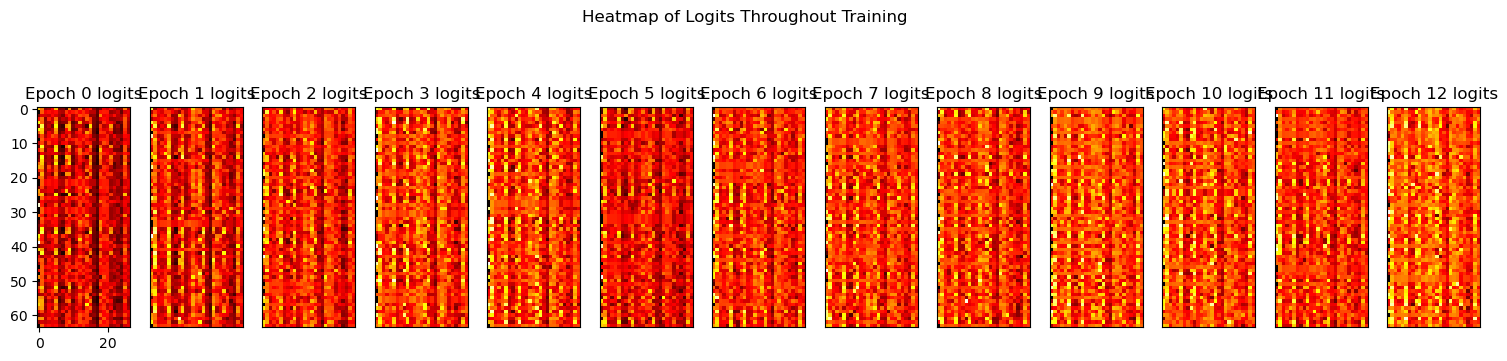

In [22]:
plt.figure()
logits_debug = logits_debug[::2]
fig, ax = plt.subplots(1, len(logits_debug), figsize=(15, 5))
for i, logits in enumerate(logits_debug):
    if i != 0:
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    ax[i].set_title(f'Epoch {i} logits')
    ax[i].imshow(logits, cmap='hot')
plt.tight_layout()
fig.suptitle('Heatmap of Logits Throughout Training')
plt.subplots_adjust(top=1.1)
plt.show()

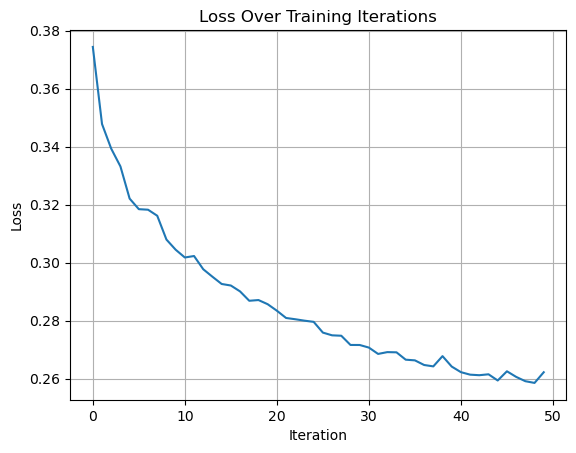

In [23]:
lossi_tensor = torch.tensor(lossi, device=device)
plt.figure()
plt.plot(lossi_tensor.view(-1, 1000).mean(1).cpu())
plt.title('Loss Over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

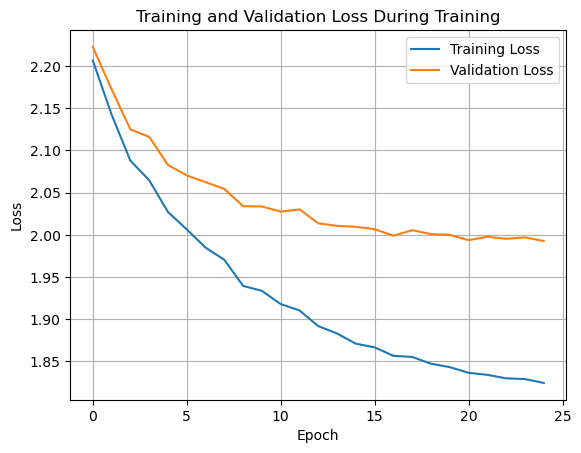

In [24]:
plt.figure()
plt.plot(tr_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

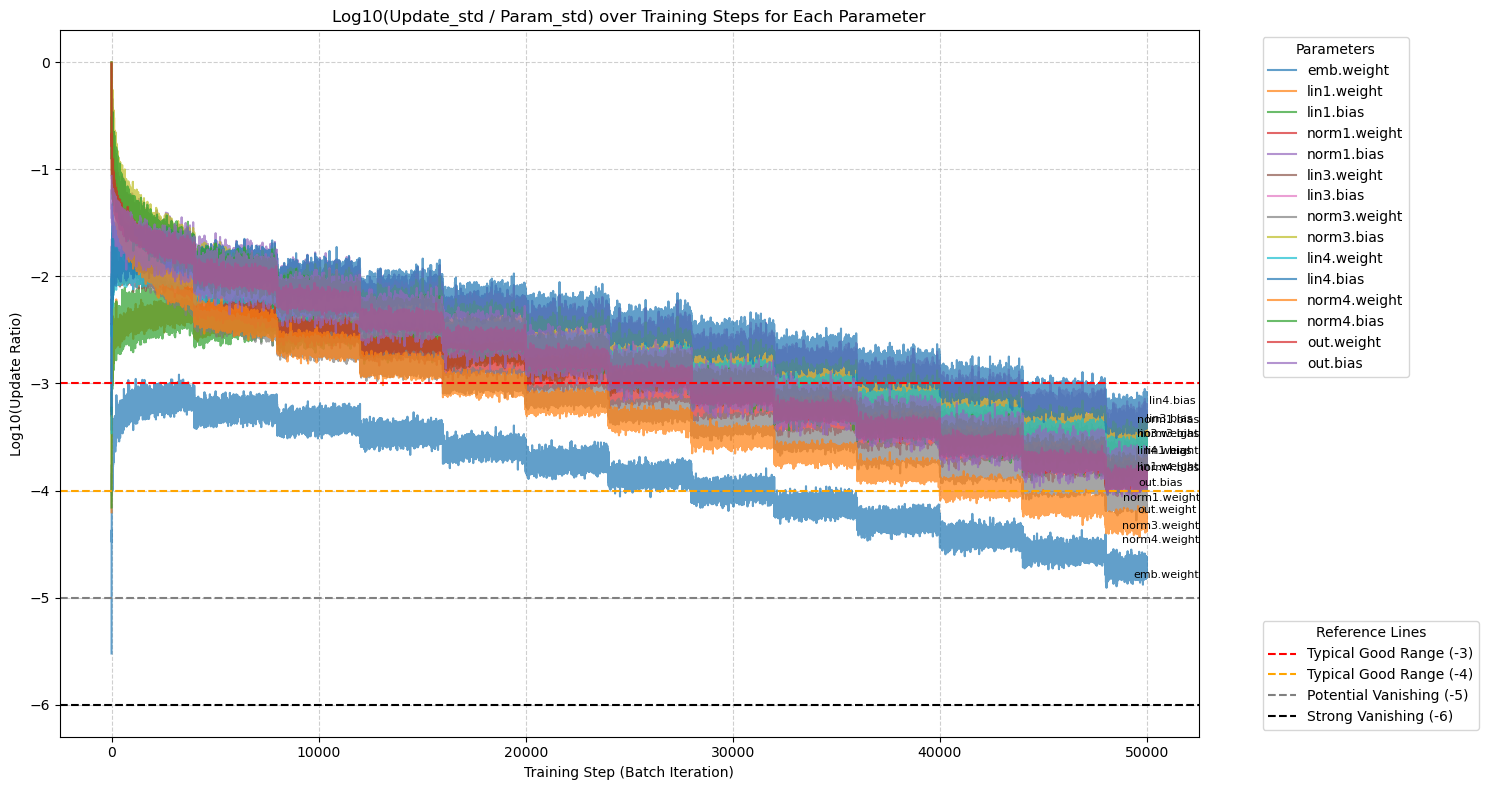

In [25]:
from adjustText import adjust_text
all_param_names = []
for step_data in ud_detail:
    for name, _ in step_data:
        if name not in all_param_names:
            all_param_names.append(name)
param_ud_trends = {name: [] for name in all_param_names}
param_ud_steps = {name: [] for name in all_param_names}
for step_index, step_data in enumerate(ud_detail):
    current_step_param_values = {name: value for name, value in step_data}
    for name in all_param_names:
        if name in current_step_param_values:
            param_ud_trends[name].append(current_step_param_values[name])
            param_ud_steps[name].append(step_index)

plt.figure(figsize=(15, 8))
plt.title('Log10(Update_std / Param_std) over Training Steps for Each Parameter')
plt.xlabel('Training Step (Batch Iteration)')
plt.ylabel('Log10(Update Ratio)')

param_handles = []
param_labels = []
texts = []

for name in all_param_names:
    valid_steps = param_ud_steps[name]
    valid_trends = param_ud_trends[name]
    if len(valid_trends) > 0:
        line, = plt.plot(valid_steps, valid_trends, label=name, alpha=0.7)
        param_labels.append(name)
        param_handles.append(line)
        # texts.append(plt.text(valid_steps[len(valid_steps)//2] + 5, valid_trends[len(valid_trends)//2], name, fontsize=8, va='center'))
        texts.append(plt.text(valid_steps[-1] + 5, valid_trends[-1], name, fontsize=8, va='center'))
        # plt.annotate(name, xy=(valid_steps[0], valid_trends[0]), xytext=(5, 0), textcoords='offset points', fontsize=8, va='center', arrowprops=dict(arrowstyle='-'))

adjust_text(texts)#, arrowprops=dict(arrowstyle='->', color='gray'))
legend1 = plt.legend(handles=param_handles, labels=param_labels, loc='upper left', bbox_to_anchor=(1.05, 1), title="Parameters")
plt.gca().add_artist(legend1)  # Needed to retain first legend

ref1 = plt.axhline(y=-3, color='r', linestyle='--', label='Typical Good Range (-3)')
ref2 = plt.axhline(y=-4, color='orange', linestyle='--', label='Typical Good Range (-4)')
ref3 = plt.axhline(y=-5, color='gray', linestyle='--', label='Potential Vanishing (-5)')
ref4 = plt.axhline(y=-6, color='black', linestyle='--', label='Strong Vanishing (-6)') # Your observed value

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside
plt.legend(handles=[ref1, ref2, ref3, ref4], loc='lower left', bbox_to_anchor=(1.05, 0), title="Reference Lines")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

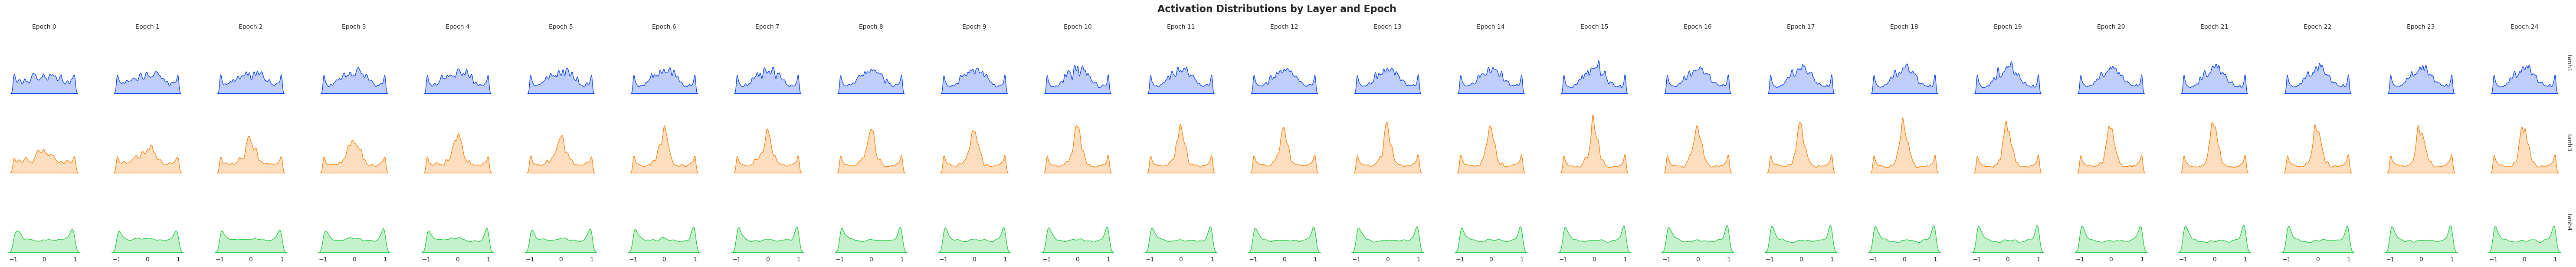

In [26]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    output_data = tanh_output_data if len(tanh_output_data) > 0 else gelu_output_data
    df = pd.DataFrame(output_data, columns=['Layer', 'Epoch', 'x'])
    df['Epoch'] = df['Epoch'].astype(int)
    df['Layer'] = df['Layer'].astype(str)

    layer_names = sorted(df['Layer'].unique())
    palette = dict(zip(layer_names, sns.color_palette("bright", n_colors=len(layer_names))))

    # Create the grid: rows = layers, columns = epochs
    g = sns.FacetGrid(df, row="Layer", col="Epoch", margin_titles=True, despine=True, height=2.0, aspect=1.2, hue='Layer', palette=palette)

    g.map(sns.kdeplot, "x", fill=True, bw_adjust=0.5, clip_on=False)

    # Cleanup for better display
    g.set_titles(row_template="{row_name}", col_template="Epoch {col_name}")
    g.set(yticks=[], ylabel="", xlabel="")
    g.despine(left=True, bottom=True)

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    g.figure.suptitle("Activation Distributions by Layer and Epoch", fontsize=16, weight='bold', y=1.05)

plt.show()

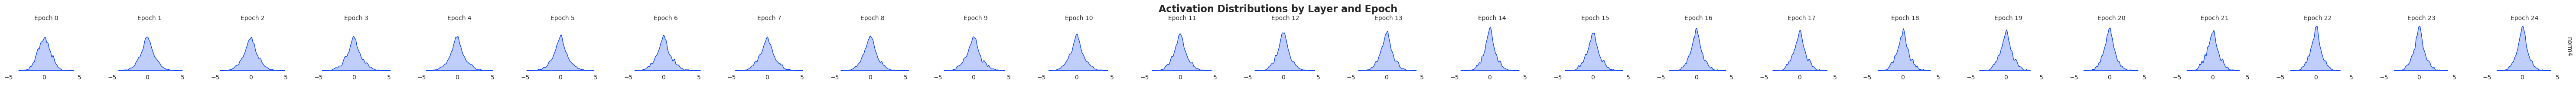

In [27]:
with sns.axes_style("white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    df = pd.DataFrame(norm4_input_data, columns=['Layer', 'Epoch', 'x'])
    df['Epoch'] = df['Epoch'].astype(int)
    df['Layer'] = df['Layer'].astype(str)

    layer_names = sorted(df['Layer'].unique())
    palette = dict(zip(layer_names, sns.color_palette("bright", n_colors=len(layer_names))))

    # Create the grid: rows = layers, columns = epochs
    g = sns.FacetGrid(df, row="Layer", col="Epoch", margin_titles=True, despine=True, height=2.0, aspect=1.2, hue='Layer', palette=palette)

    g.map(sns.kdeplot, "x", fill=True, bw_adjust=0.5, clip_on=False)

    # Cleanup for better display
    g.set_titles(row_template="{row_name}", col_template="Epoch {col_name}")
    g.set(yticks=[], ylabel="", xlabel="")
    g.despine(left=True, bottom=True)

    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    g.figure.suptitle("Activation Distributions by Layer and Epoch", fontsize=16, weight='bold', y=1.05)

plt.show()

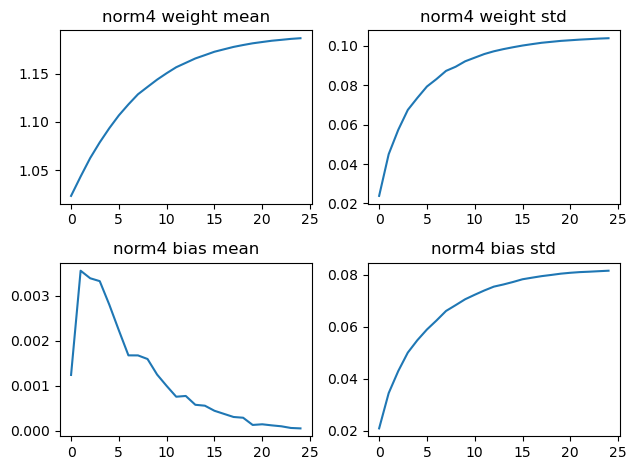

In [28]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(norm4_weight_means)
axs[0, 0].set_title('norm4 weight mean')

axs[0, 1].plot(norm4_weight_stds)
axs[0, 1].set_title('norm4 weight std')

axs[1, 0].plot(norm4_bias_means)
axs[1, 0].set_title('norm4 bias mean')

axs[1, 1].plot(norm4_bias_stds)
axs[1, 1].set_title('norm4 bias std')

plt.tight_layout()
plt.show()

Weight torch.Size([27, 16]), mean: -0.0006, std: 0.0130, grad:data ratio: 0.013572055846452713
Weight torch.Size([512, 48]), mean: 0.0000, std: 0.0120, grad:data ratio: 0.1293485313653946
Weight torch.Size([256, 1024]), mean: -0.0000, std: 0.0060, grad:data ratio: 0.21767720580101013
Weight torch.Size([128, 512]), mean: 0.0000, std: 0.0076, grad:data ratio: 0.18617910146713257
Weight torch.Size([27, 128]), mean: -0.0000, std: 0.0129, grad:data ratio: 0.08626177161931992


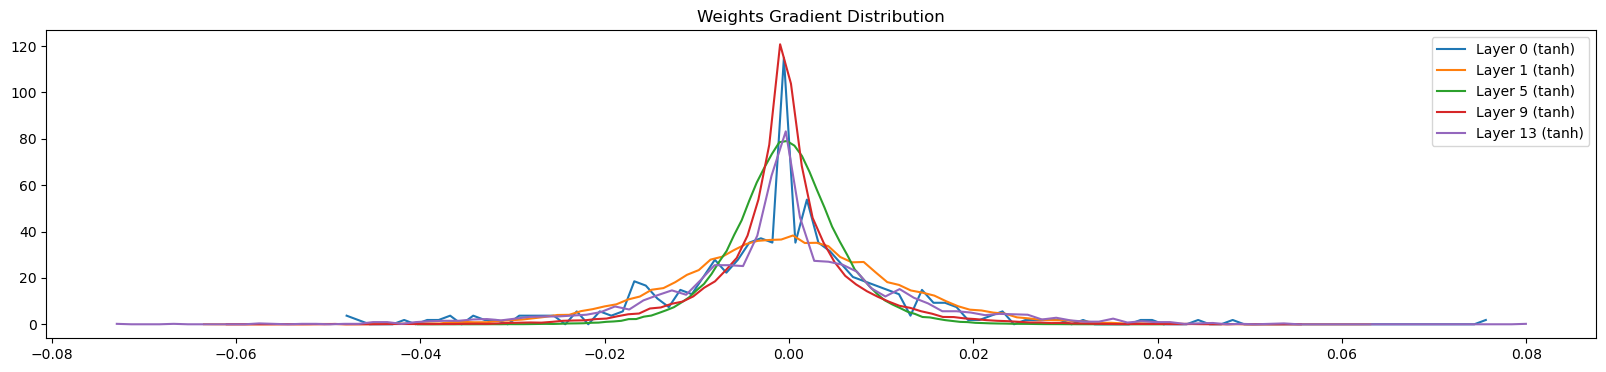

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(model.parameters()):
    if p.ndim == 2:
        t = p.grad
        print(f'Weight {p.shape}, mean: {t.mean():.4f}, std: {t.std():.4f}, grad:data ratio: {t.std() / p.std()}')
        hy, hx = torch.histogram(t.cpu(), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} (tanh)')
plt.legend(legends)
plt.title('Weights Gradient Distribution')
plt.show()

In [30]:
g = torch.Generator(device=device).manual_seed(TORCH_GENERATOR_SEED + 22)

with torch.no_grad():
    for _ in range(20):
        out = []
        context = [0 for _ in range(block_size)]

        while True:
            context_tensor = torch.tensor([context], device=device)

            logits = model(context_tensor)
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()

            context = context[1:] + [ix]
            out.append(ix)

            if ix == 0:
                break

        print(str().join(itos[i] for i in out))

jakari.
geus.
trish.
melonia.
zamar.
zaneda.
joton.
anyton.
hari.
laylen.
ahana.
delon.
marlynn.
fmenayde.
stella.
shaudeal.
jounab.
diana.
ilion.
yure.
